# Assignment #3

# Multidimensional data visualization. Chernoff faces. Advanced programming with Matplotlib.


## Init

In [1]:
!rm -rf ./sample_data/
!wget -O data.zip http://visualdata.wustl.edu/varepository/VAST%20Challenge%202016/challenges/Mini-Challenge%202/dataset/MC2%20Data.zip

--2022-11-07 19:51:09--  http://visualdata.wustl.edu/varepository/VAST%20Challenge%202016/challenges/Mini-Challenge%202/dataset/MC2%20Data.zip
Resolving visualdata.wustl.edu (visualdata.wustl.edu)... 128.252.202.244
Connecting to visualdata.wustl.edu (visualdata.wustl.edu)|128.252.202.244|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18369530 (18M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  17,52M  2,23MB/s    in 8,2s    

2022-11-07 19:51:17 (2,15 MB/s) - ‘data.zip’ saved [18369530/18369530]



In [2]:
import zipfile

zip_filepath='./data.zip'

with zipfile.ZipFile(zip_filepath) as z:
  with z.open("MCBuildingProxSensorData.zip") as inner_zip:
    with zipfile.ZipFile(inner_zip) as inner:
      print(inner.namelist())
      with open('data.csv', 'wb') as f:
        f.write(inner.read('csv/bldg-MC2.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/data.zip'

## Creating a dataframe

### About data

| **Field** | **Units** | **Description** |
|---|---|---|
| **F_3_Z_8: Lights Power** | [W]  | Power used by the lights in the zone |
| **F_3_Z_8: Equipment Power** | [W] | Power used by the electric equipment in the zone |
| **F_3_Z_8: Thermostat Temp** | [C]  | Temperature of the air inside the zone |
| **F_3_Z_8: Thermostat Cooling Setpoint** | [C]  | Cooling set point schedule for the zone |
| **F_3_Z_8: Thermostat Heating Setpoint** | [C]  | Heating set point schedule for the zone |
| **F_3_Z_8: VAV REHEAT Damper Position** |  | Position of the zone's air supply box damper. 1 corresponds to fully open, 0 corresponds to fully closed |
| **F_3_Z_8: REHEAT COIL Power** | [W] | Power used by the zone air supply box reheat coil |
| **F_3_Z_8: RETURN OUTLET CO2 Concentration** | [ppm] | Concentration of C02 measured at the zone's return air grille |
| **F_3_Z_8: SUPPLY INLET Temperature** | [C]  | Temperature of the air entering the zone from its air supply box |
| **F_3_Z_8: SUPPLY INLET Mass Flow Rate** | [kg/s] | Flow rate of the air entering the zone from its air supply box |



### Extract data

In [ ]:
import pandas as pd

data = pd.read_csv('./data.csv')
data = data.rename(columns=lambda x: x.strip())

In [ ]:
tracked_columns =[
  "Date/Time",
  "F_3_Z_8: Lights Power",
  "F_3_Z_8: Equipment Power",
  "F_3_Z_8: Thermostat Temp",
  "F_3_Z_8: Thermostat Heating Setpoint",
  "F_3_Z_8: Thermostat Cooling Setpoint",
  "F_3_Z_8 VAV REHEAT Damper Position",
  "F_3_Z_8 REHEAT COIL Power",
  "F_3_Z_8 RETURN OUTLET CO2 Concentration",
  "F_3_Z_8 SUPPLY INLET Temperature",
  "F_3_Z_8 SUPPLY INLET Mass Flow Rate"
]

data = data[tracked_columns]

# Split date/time in two columns
date_column = data.apply(lambda row: row["Date/Time"].split()[0], axis = 1)
time_column = data.apply(lambda row: row["Date/Time"].split()[1], axis = 1)

data.insert(0, 'Date', date_column)
data.insert(1, 'Time', time_column)

data = data.drop('Date/Time', axis=1)

In [ ]:
data.head()

,Date,Time,F_3_Z_8: Lights Power,F_3_Z_8: Equipment Power,F_3_Z_8: Thermostat Temp,F_3_Z_8: Thermostat Heating Setpoint,F_3_Z_8: Thermostat Cooling Setpoint,F_3_Z_8 VAV REHEAT Damper Position,F_3_Z_8 REHEAT COIL Power,F_3_Z_8 RETURN OUTLET CO2 Concentration,F_3_Z_8 SUPPLY INLET Temperature,F_3_Z_8 SUPPLY INLET Mass Flow Rate
0,2016-05-31,00:00:00,0.0,167.939,23.3004,15.6,26.7,0.2,0.0,473.9997,12.8008,0.0988
1,2016-05-31,00:05:00,0.0,167.939,23.2863,15.6,26.7,0.2,0.0,473.4399,12.8008,0.0988
2,2016-05-31,00:10:00,0.0,167.939,23.2711,15.6,26.7,0.2,0.0,472.8899,12.8000,0.0988
3,2016-05-31,00:15:00,0.0,167.939,23.2554,15.6,26.7,0.2,0.0,472.3491,12.8007,0.0988
4,2016-05-31,00:20:00,0.0,167.939,23.2393,15.6,26.7,0.2,0.0,471.8170,12.8004,0.0988


### Split data into datasets by date

In [ ]:
days_data_list = []

for group, dataframe in data.groupby('Date'):   
  days_data_list.append(dataframe)   
  dataframe.to_csv(f'{group}.csv', index=False)

## Correlation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

import numpy as np

import seaborn as sns

from IPython.display import Image

In [ ]:
def get_empty_columns_names(df):
  empty = [col for col in df.columns if (df[col].isnull().all() or df[col].isna().all())]
  return empty

In [ ]:
def heatmap(df, ax, title):
  corr = df.corr()
  
  # Select only strong correlation
  dfCorr = corr[((corr >= .7) | (corr <= -.7))]

  print("Empty columns:", get_empty_columns_names(dfCorr))

  mask = np.triu(np.ones_like(corr))
  sns.heatmap(
    dfCorr, 
    cbar=False, 
    mask=mask,
    ax=ax, 
    annot=True, 
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
  )

  ax.title.set_text(f"{title}")
  ax.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
  )

In [ ]:
fig, ax = plt.subplots(
  nrows=4, 
  ncols=4, 
  sharey=True, 
  sharex=True, 
  figsize=(40, 20), 
  constrained_layout=True
)

axes = ax.flatten()

for i in range(len(days_data_list)):
  df = days_data_list[i]
  ax = axes[i]
  heatmap(df, ax, df.Date.iat[0])

for ax in axes.flat[len(days_data_list):]:
    ax.remove()

plt.savefig("heatmaps.png", bbox_inches="tight")
plt.close()

Empty columns: ['F_3_Z_8 REHEAT COIL Power']
Empty columns: ['F_3_Z_8 REHEAT COIL Power']
Empty columns: ['F_3_Z_8 REHEAT COIL Power']
Empty columns: []
Empty columns: ['F_3_Z_8: Lights Power', 'F_3_Z_8: Equipment Power', 'F_3_Z_8: Thermostat Heating Setpoint', 'F_3_Z_8: Thermostat Cooling Setpoint', 'F_3_Z_8 VAV REHEAT Damper Position', 'F_3_Z_8 SUPPLY INLET Mass Flow Rate']
Empty columns: ['F_3_Z_8: Lights Power', 'F_3_Z_8: Equipment Power', 'F_3_Z_8: Thermostat Heating Setpoint', 'F_3_Z_8: Thermostat Cooling Setpoint', 'F_3_Z_8 VAV REHEAT Damper Position', 'F_3_Z_8 SUPPLY INLET Mass Flow Rate']
Empty columns: []
Empty columns: []
Empty columns: []
Empty columns: []
Empty columns: []
Empty columns: ['F_3_Z_8: Thermostat Heating Setpoint', 'F_3_Z_8: Thermostat Cooling Setpoint', 'F_3_Z_8 VAV REHEAT Damper Position', 'F_3_Z_8 SUPPLY INLET Mass Flow Rate']
Empty columns: ['F_3_Z_8: Thermostat Heating Setpoint', 'F_3_Z_8: Thermostat Cooling Setpoint', 'F_3_Z_8 VAV REHEAT Damper Position'

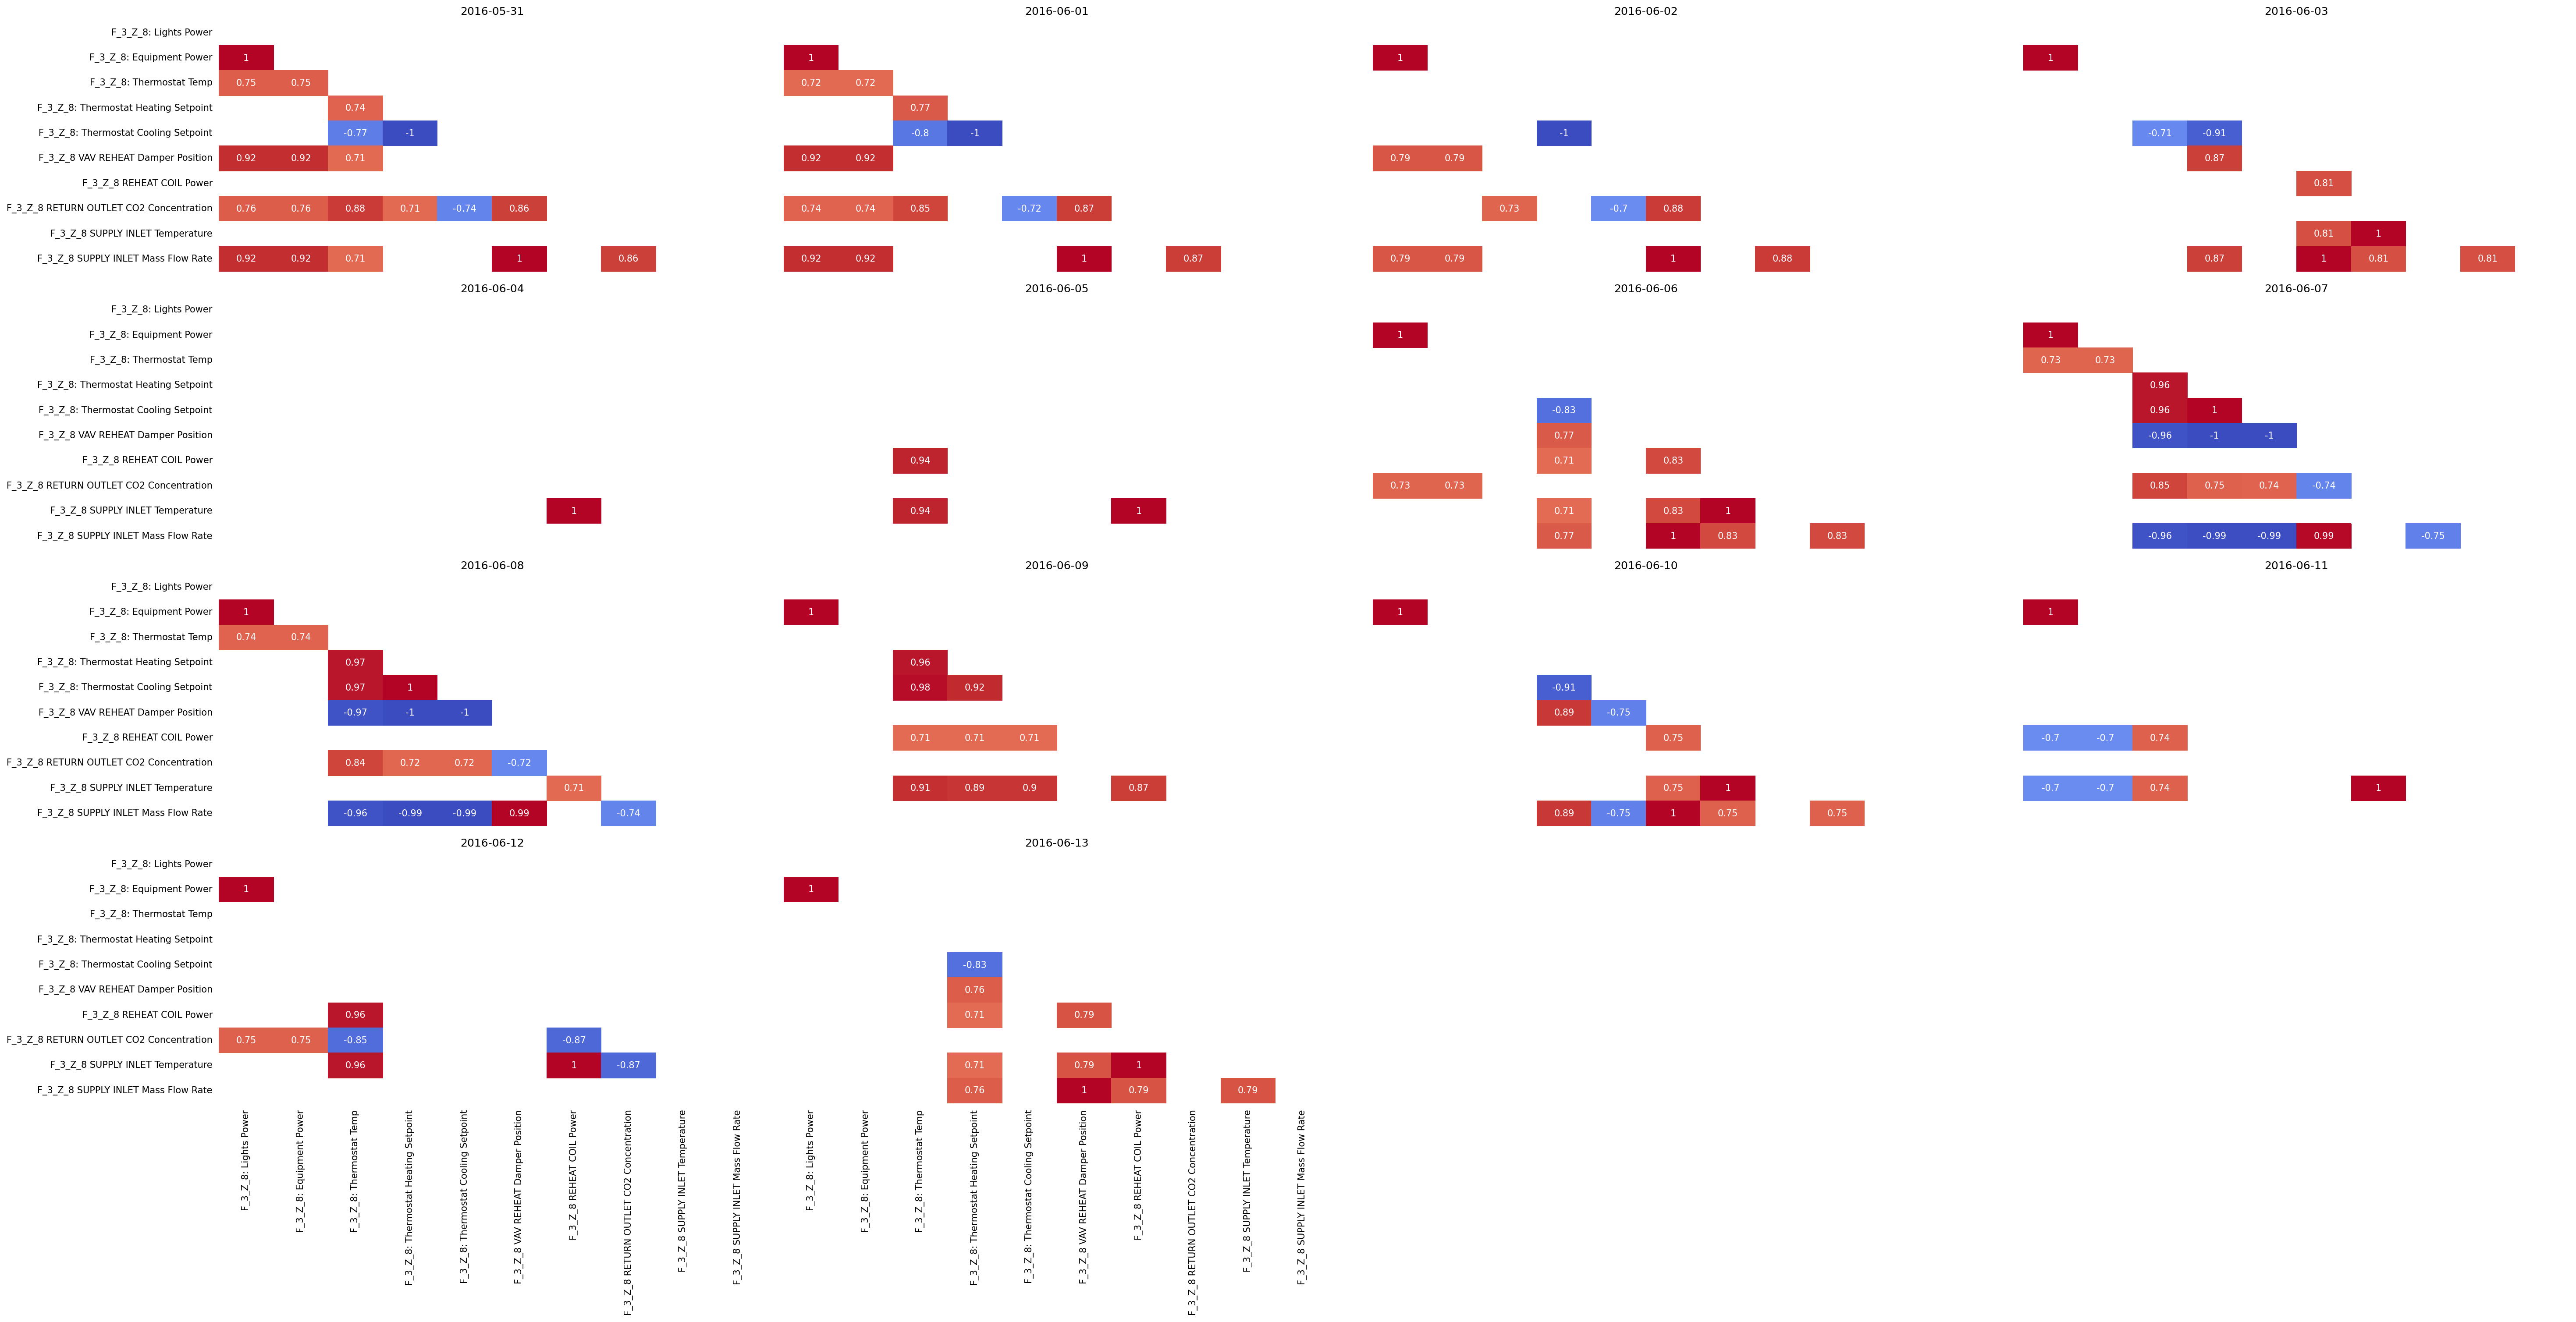

In [ ]:
img = Image("heatmaps.png", width=2000)
img

Some of the columns in certain days had no strong correlation with other columns, but it was decided to leave this columns be in the dataset, since on most days these columns had a strong correlation with other columns.

## Chernoff faces implementation

### Mapping

| **Field** | **Face feature** |
|---|---|
| **F_3_Z_8: Lights Power** | Curvature of the eyebrow |
| **F_3_Z_8: Equipment Power** | Height of the eye |
| **F_3_Z_8: Thermostat Temp** | Skin color |
| **F_3_Z_8: Thermostat Cooling Setpoint** | Height of the right side of the hair |
| **F_3_Z_8: Thermostat Heating Setpoint** | Height of the left side of the hair|
| **F_3_Z_8: VAV REHEAT Damper Position** | Height of the mouth |
| **F_3_Z_8: REHEAT COIL Power** | Size of the pupil |
| **F_3_Z_8: RETURN OUTLET CO2 Concentration** | Width of the nose |
| **F_3_Z_8: SUPPLY INLET Temperature** | Hair color |
| **F_3_Z_8: SUPPLY INLET Mass Flow Rate** | Width of the mouth |



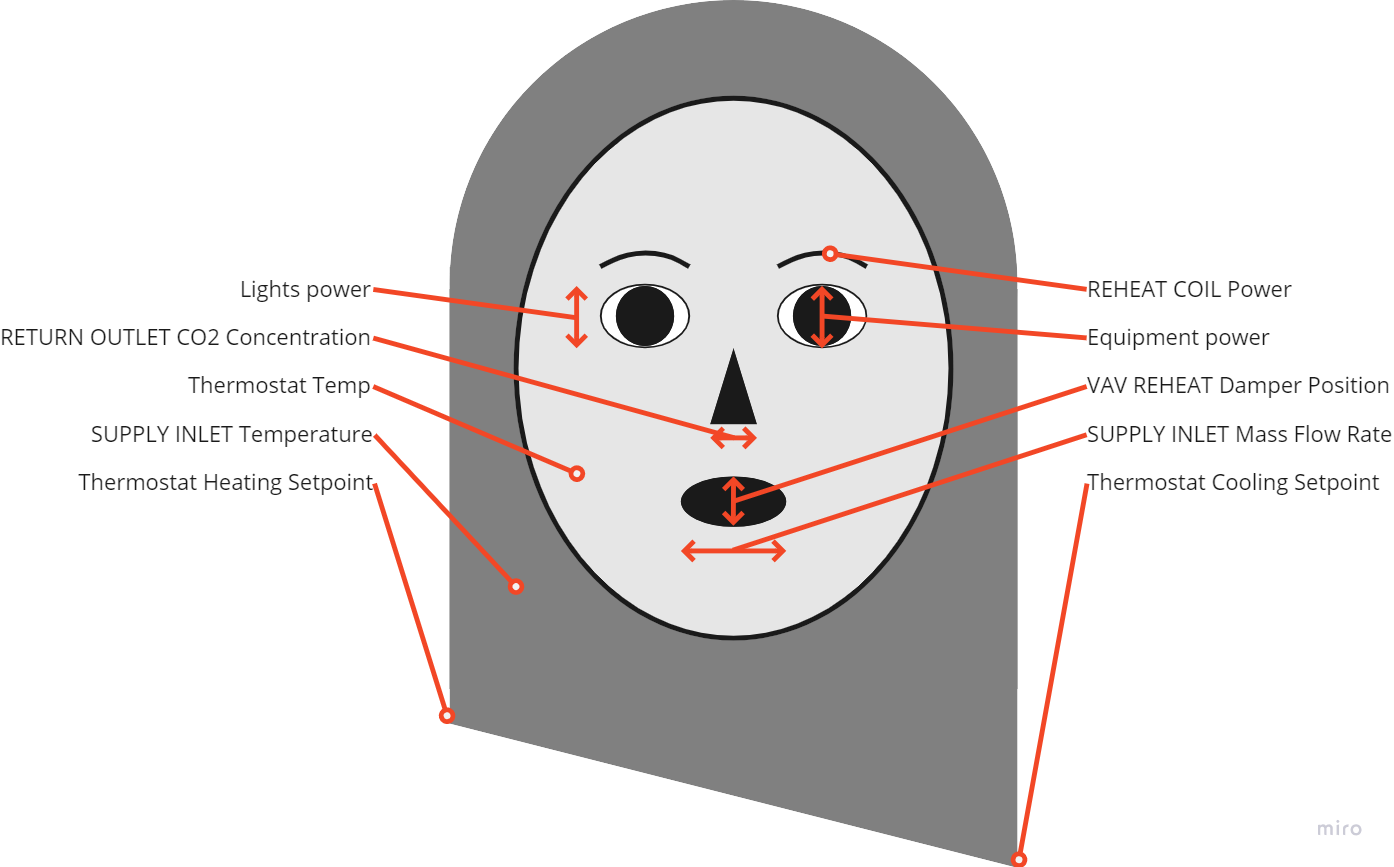

### Code

In [ ]:
mean_data = []

for i, df in enumerate(days_data_list):
  mean_data.append([df.Date.iat[0], *df.mean().tolist()])


mean_df = pd.DataFrame(mean_data, columns=[ 
  "Date",
  "F_3_Z_8: Lights Power",
  "F_3_Z_8: Equipment Power",
  "F_3_Z_8: Thermostat Temp",
  "F_3_Z_8: Thermostat Heating Setpoint",
  "F_3_Z_8: Thermostat Cooling Setpoint",
  "F_3_Z_8 VAV REHEAT Damper Position",
  "F_3_Z_8 REHEAT COIL Power",
  "F_3_Z_8 RETURN OUTLET CO2 Concentration",
  "F_3_Z_8 SUPPLY INLET Temperature",
  "F_3_Z_8 SUPPLY INLET Mass Flow Rate"
])

mean_df.to_csv('mean_df.csv', index=False)

# Reindex dataframe to fit config properties order
mean_df = mean_df.reindex(columns=[ 
  "Date",
  "F_3_Z_8 SUPPLY INLET Temperature",
  "F_3_Z_8: Thermostat Heating Setpoint",
  "F_3_Z_8: Thermostat Cooling Setpoint",
  "F_3_Z_8 REHEAT COIL Power",  
  "F_3_Z_8: Lights Power",
  "F_3_Z_8: Equipment Power",
  "F_3_Z_8 RETURN OUTLET CO2 Concentration", 
  "F_3_Z_8 VAV REHEAT Damper Position",
  "F_3_Z_8 SUPPLY INLET Mass Flow Rate",
  "F_3_Z_8: Thermostat Temp", 
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, PathPatch, Arc, Polygon, Wedge
import matplotlib.path as mpath

Path = mpath.Path

class ChernoffFaces:
  DATA = {
    "HAIR_COLOR": None,
    "HAIR_LEFT": None,
    "HAIR_RIGHT": None,
    "EYEBROW_CURVATURE": None,
    "EYE_HEIGHT": None,
    "PUPIL_SIZE": None,        
    "NOSE_WIDTH": None,
    "MOUTH_HEIGHT": None,
    "MOUTH_WIDTH": None,
    "SKIN_COLOR": None,    
  }

  def __init__(
      self, 
      df, 
      labels=None, 
      filename='faces'
  ):
    if not labels:
      self.labels = df.iloc[:,0].values
      df = df[df.columns.drop(df.columns[0])]
    
    self.data = pd.DataFrame(
      min_max_scaler.fit_transform(df.values), 
      columns=df.columns
    )


    for index, key in enumerate(self.DATA.keys()):
      self.DATA[key] = self.data[self.data.columns[index % len(self.data.columns)]].values.tolist()


    self.filename = filename

  def render_face(self, ax, title='', index=None):
    height, width = ax.bbox.height, ax.bbox.width
  

    self.draw_hair(ax, index, width, height)
    self.draw_face(ax, index, width, height)
    self.draw_brows(ax, index)
    self.draw_eyes(ax, index)
    self.draw_pupils(ax, index)
    self.draw_nose(ax, index)   
    self.draw_mouth(ax, index)


    ax.title.set_text(f"{title}")

    ax.axis('off')
    ax.autoscale()

  def draw_hair(self, ax, index, width, height):
    hair_width = width
    hair_height = height

    colour = plt.cm.coolwarm(self.DATA["HAIR_COLOR"][index])

    trapeze = Polygon(
      xy=[
        [0, hair_height * 0.5 * (1 - self.DATA["HAIR_LEFT"][index])],
        [0, hair_height * 0.5],
        [hair_width, hair_height * 0.5],
        [hair_width, hair_height * 0.5 * (1 - self.DATA["HAIR_RIGHT"][index])],
      ], 
      fc=colour
    )
    ax.add_patch(trapeze)

    top = Wedge(
      center=[hair_width / 2, hair_height * 0.5 - 1], 
      r=hair_width / 2,
      theta1=0, 
      theta2=180,
      edgecolor='none', 
      fc=colour,
    )
    ax.add_patch(top)

  def draw_face(self, ax, index, width, height):
    face_width = width * 2/3
    face_height = height * 1/2
    self.UNIT_WIDTH = face_width / 7
    self.UNIT_HEIGHT = face_height / 7
    self.FACE_CENTER = [width / 2, height / 2]

    colour = plt.cm.coolwarm(self.DATA["SKIN_COLOR"][index])

    ellipse = Ellipse(
      xy=self.FACE_CENTER, 
      width=face_width, 
      height=face_height, 
      edgecolor='black', 
      fc=colour, 
      lw=2
    )
    ax.add_patch(ellipse)
  
  def draw_brows(self, ax, index):
    brow_width = self.UNIT_WIDTH * 1.5
    brow_height =  self.UNIT_HEIGHT * self.DATA["EYEBROW_CURVATURE"][index]
    if brow_height == 0:
      brow_height = 0.001

    brow_l_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [brow_width,  self.UNIT_HEIGHT * 1.1] 
    ])]

    brow_r_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [-brow_width,  self.UNIT_HEIGHT * 1.1] 
    ])]

    brow_l = Arc(
      xy=brow_l_center, 
      width=brow_width, 
      height=brow_height, 
      theta1=0, 
      theta2=180,
      edgecolor='black', 
      fc='None', 
      lw=2
    )
    ax.add_patch(brow_l)

    brow_r = Arc(
      xy=brow_r_center, 
      width=brow_width, 
      height=brow_height, 
      theta1=0, 
      theta2=180,
      edgecolor='black', 
      fc='None', 
      lw=2
    )
    ax.add_patch(brow_r)

  def draw_eyes(self, ax, index):
    eye_width = self.UNIT_WIDTH * 1.5
    eye_height =  self.UNIT_HEIGHT * self.DATA["EYE_HEIGHT"][index] 
    if eye_height == 0:
      eye_height = 0.001

    eye_l_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [-eye_width,  self.UNIT_HEIGHT / 2] 
    ])]

    eye_r_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [eye_width,  self.UNIT_HEIGHT / 2] 
    ])]

    ellipse = Ellipse(
      xy=eye_l_center, 
      width=eye_width, 
      height=eye_height, 
      edgecolor='black', 
      fc='white', 
      lw=1
    )
    ax.add_patch(ellipse)

    ellipse = Ellipse(
      xy=eye_r_center, 
      width=eye_width, 
      height=eye_height, 
      edgecolor='black', 
      fc='white', 
      lw=1
    )
    ax.add_patch(ellipse)   

  def draw_pupils(self, ax, index):
    pupil_width = self.UNIT_WIDTH * self.DATA["PUPIL_SIZE"][index] 
    pupil_height = pupil_width
    eye_width = self.UNIT_WIDTH * 1.5
    if pupil_height == 0:
      pupil_height = 0.001

    pupil_l_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [-eye_width,  self.UNIT_HEIGHT / 2] 
    ])]

    pupil_r_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [eye_width,  self.UNIT_HEIGHT / 2] 
    ])]

    ellipse = Ellipse(
      xy=pupil_l_center, 
      width=pupil_width, 
      height=pupil_height, 
      edgecolor='black', 
      fc='black', 
      lw=1
    )
    ax.add_patch(ellipse)

    ellipse = Ellipse(
      xy=pupil_r_center, 
      width=pupil_width, 
      height=pupil_height, 
      edgecolor='black', 
      fc='black', 
      lw=1
    )
    ax.add_patch(ellipse)   

  def draw_nose(self, ax, index):
    nose_width = self.UNIT_WIDTH * (1 - self.DATA["NOSE_WIDTH"][index])
    nose_height =  self.UNIT_HEIGHT  

    pivot_left = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [-nose_width / 2,  -nose_height] 
    ])]
    
    pivot_right = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [nose_width / 2,  -nose_height] 
    ])]

    pivot_top = self.FACE_CENTER

    points = np.array([pivot_left, pivot_right, pivot_top])
    nose = plt.Polygon(
      points, 
      closed=True, 
      lw=1,
      fc="black", 
      edgecolor='black',
    )
    ax.add_patch(nose)

  def draw_mouth(self, ax, index):
    mouth_width = self.UNIT_WIDTH * 3 * self.DATA["MOUTH_WIDTH"][index] 
    mouth_height = self.UNIT_HEIGHT * 1.5 * self.DATA["MOUTH_HEIGHT"][index] 

    mouth_center = [sum(i) for i in zip(*[ 
      self.FACE_CENTER, 
      [0,  -self.UNIT_HEIGHT * 2] 
    ])]

    ellipse = Ellipse(
      xy=mouth_center, 
      width=mouth_width, 
      height=mouth_height, 
      edgecolor='black', 
      fc="black",  
      lw=1
    )
    ax.add_patch(ellipse)

  def render(
      self,
      n_cols=1, 
      n_rows=1,
      figsize=(2, 2),
      empty_cols_ids=None
  ):
    fig, ax = plt.subplots(
      nrows=n_rows, 
      ncols=n_cols, 
      figsize=figsize, 
      sharey=True,
      sharex=True,
      constrained_layout=True,
      frameon=False,
    )

    axes = ax.flatten()

    j = 0
    for i in range(len(axes)):
      ax = axes[i]
      if i in empty_cols_ids:
        ax.remove()
      else:
        self.render_face(ax, title=self.labels[j], index=j)
        j += 1

    plt.savefig(f"{self.filename}.png", bbox_inches="tight")
    plt.close()

In [ ]:
c = ChernoffFaces(mean_df)
c.render(
  n_cols=7, 
  n_rows = 3,
  figsize=(20, 12),
  empty_cols_ids=[0, *np.arange(len(mean_df.index)+1, 21)]
)

In [ ]:
c.data

,F_3_Z_8 SUPPLY INLET Temperature,F_3_Z_8: Thermostat Heating Setpoint,F_3_Z_8: Thermostat Cooling Setpoint,F_3_Z_8 REHEAT COIL Power,F_3_Z_8: Lights Power,F_3_Z_8: Equipment Power,F_3_Z_8 RETURN OUTLET CO2 Concentration,F_3_Z_8 VAV REHEAT Damper Position,F_3_Z_8 SUPPLY INLET Mass Flow Rate,F_3_Z_8: Thermostat Temp
0,0.000002,0.000000,0.133253,0.000000,0.960317,0.960317,0.226223,0.124847,0.057012,0.000000
1,0.000011,0.000000,0.133253,0.000000,0.968254,0.968254,0.242477,0.142187,0.075698,0.012373
2,0.000000,0.000000,0.133253,0.000000,0.944444,0.944444,0.239772,0.187948,0.124990,0.044384
3,0.184996,0.191345,0.101180,0.242003,0.904762,0.904762,0.231053,0.418379,0.373298,0.061089
4,0.725293,0.776276,0.000000,0.949039,0.000000,0.000000,0.042656,1.000000,1.000000,0.102083
5,0.764296,0.776276,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.102246
6,0.187655,0.290763,0.048188,0.245691,1.000000,1.000000,0.208891,0.377943,0.329721,0.068022
7,0.236904,0.352048,0.064881,0.051989,1.000000,1.000000,0.762462,0.345292,0.300835,0.208311
8,0.160987,0.350346,0.059127,0.047489,0.984127,0.984127,1.000000,0.349964,0.304706,0.231576
9,1.000000,1.000000,1.000000,0.429751,0.841270,0.841270,0.465829,0.000000,0.000000,1.000000


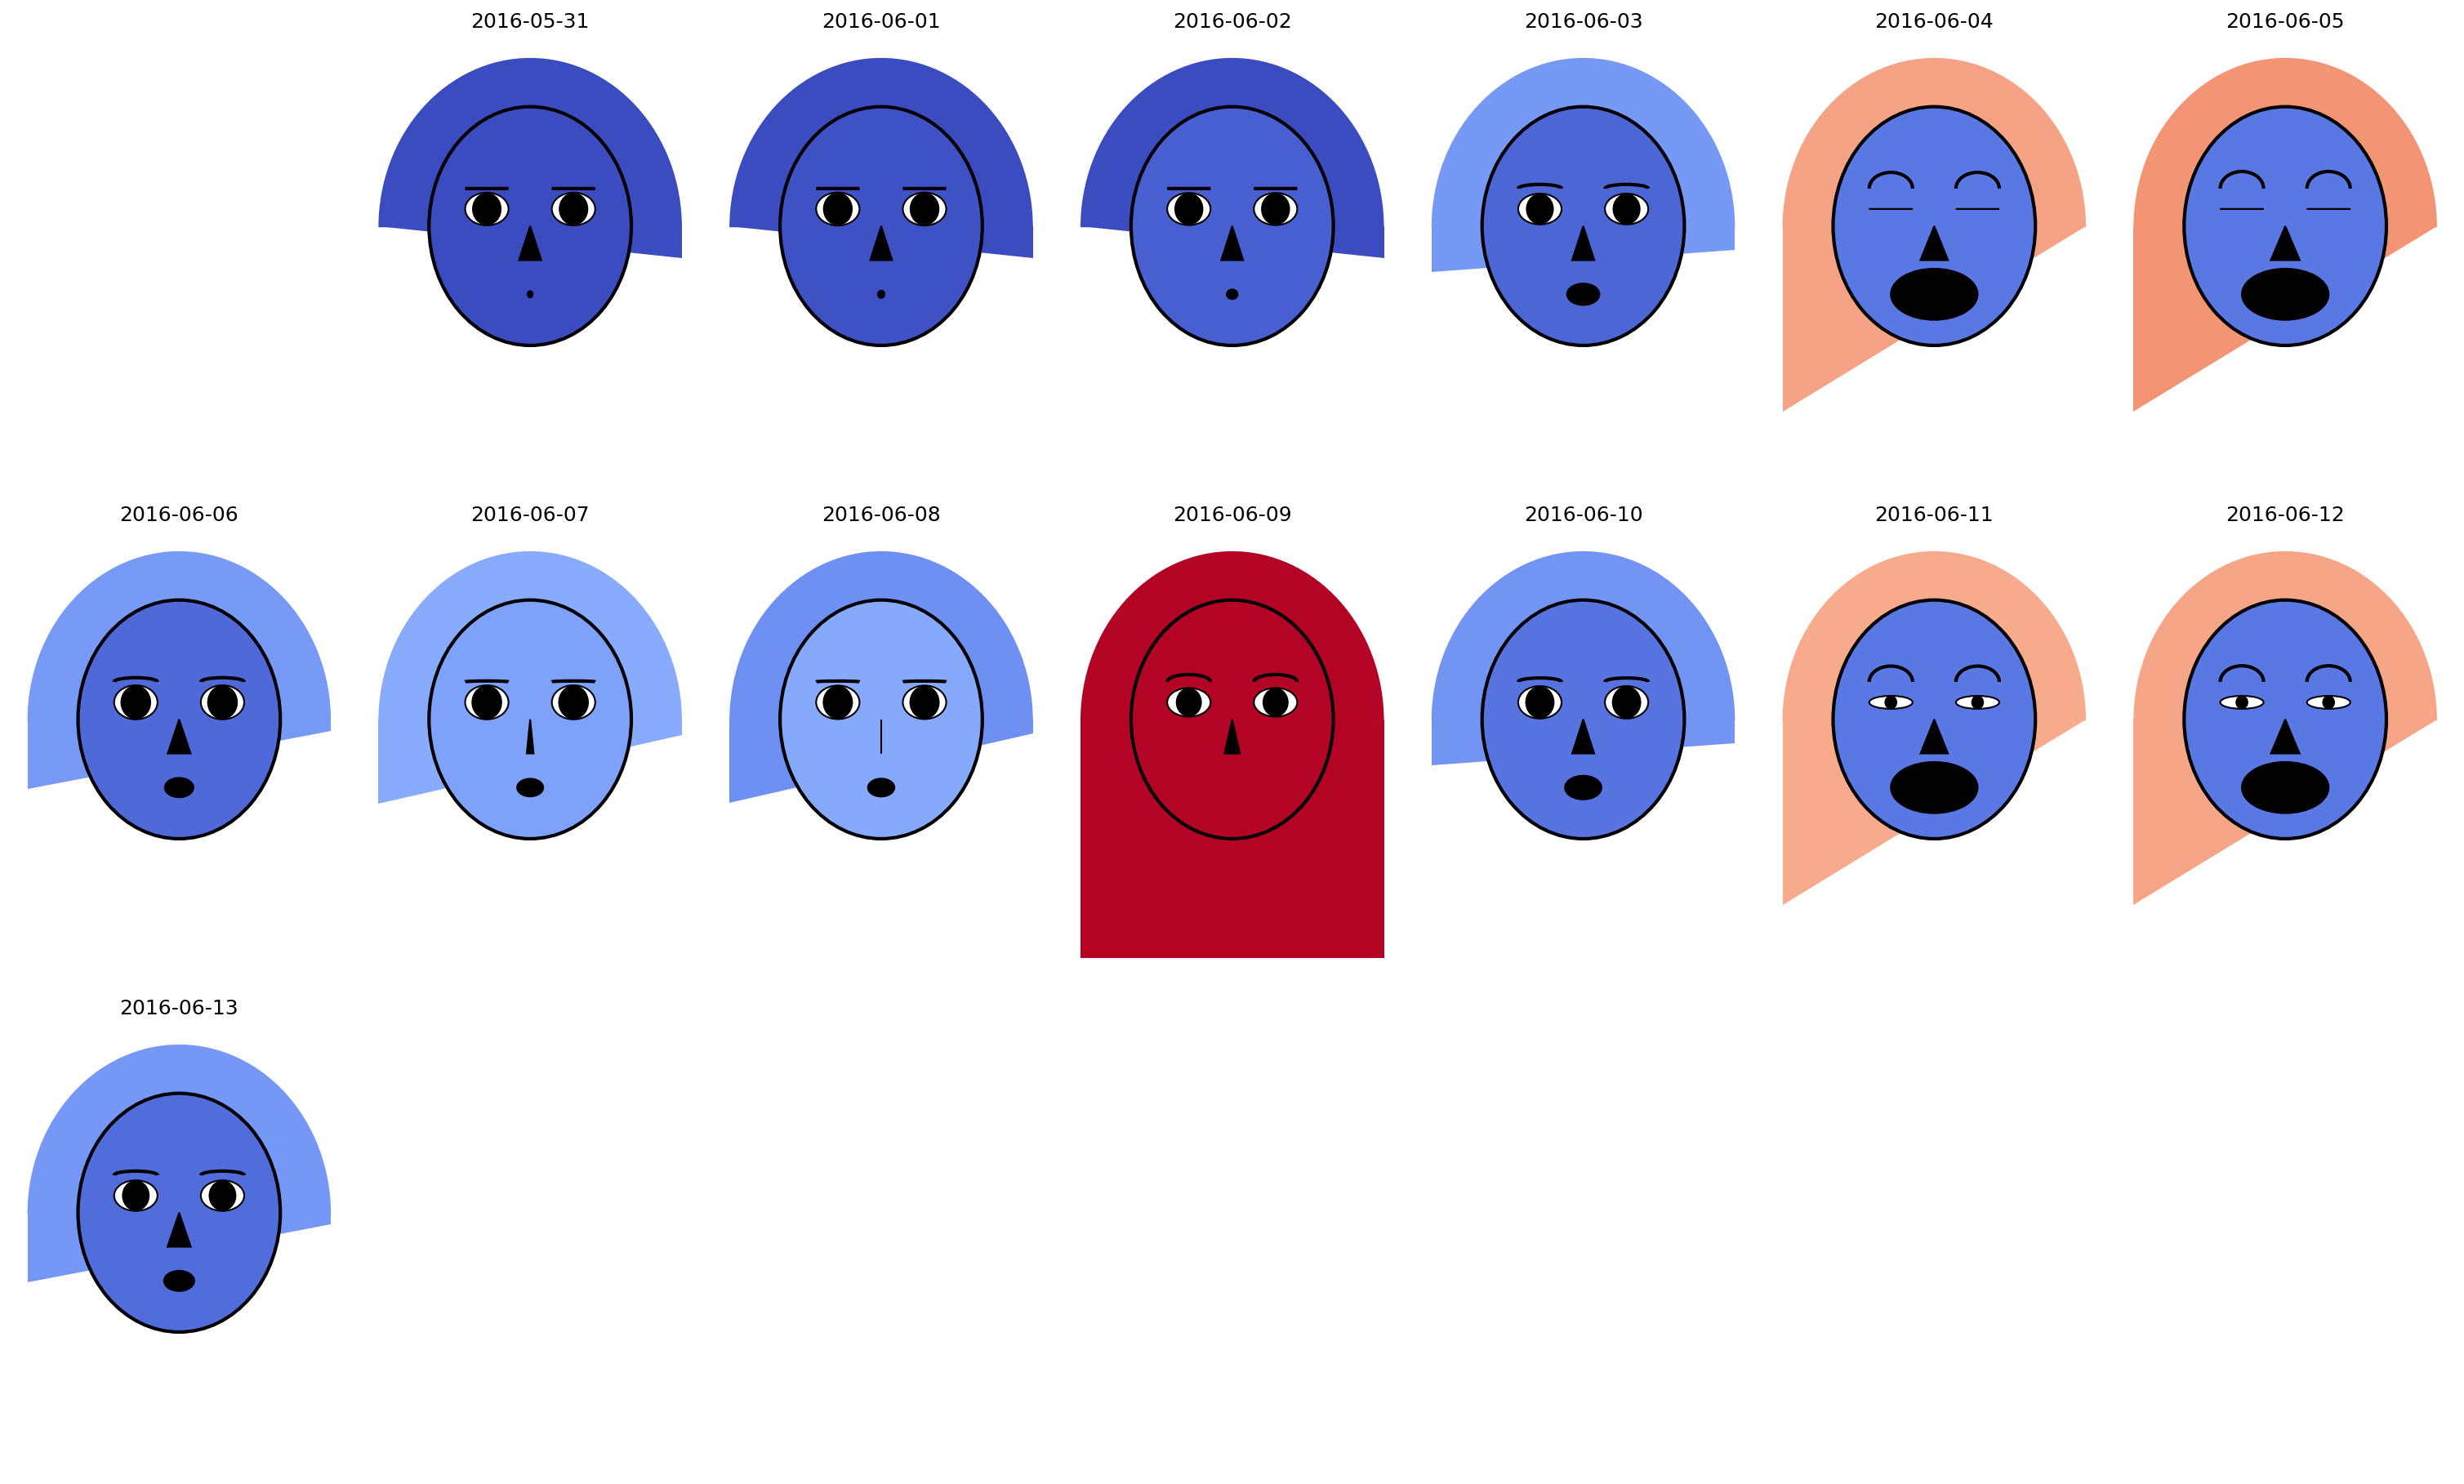

In [ ]:
img = Image("faces.png", width=2000)
img